# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# full train set and official test set
full_train = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)

# split full train into train/val
train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  pin_memory=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, pin_memory=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, pin_memory=True, num_workers=2)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose ToTensor() and Normalize() because they prepare the data in the right format, scale the inputs for stable training, and ensure the model learns efficiently. Since MNIST is already clean and uniform, heavier preprocessing wasn’t needed at this stage.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


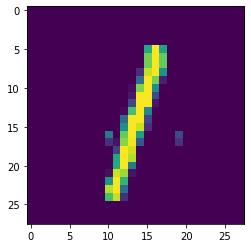

3


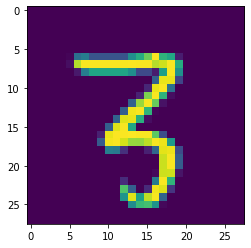

7


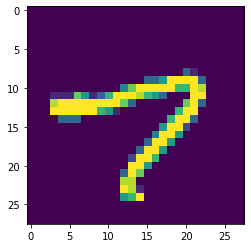

7


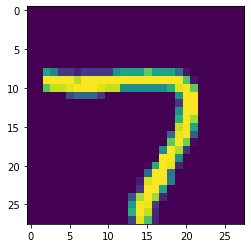

7


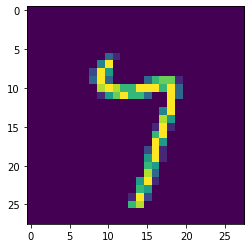

In [6]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)  # logits

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)               
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Move the model to the GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 76.48% training loss: 0.75280
Epoch 1 validation accuracy: 89.95% validation loss: 0.34509
Epoch 2 training accuracy: 91.46% training loss: 0.28708
Epoch 2 validation accuracy: 91.81% validation loss: 0.28720
Epoch 3 training accuracy: 92.58% training loss: 0.25245
Epoch 3 validation accuracy: 91.40% validation loss: 0.30555
Epoch 4 training accuracy: 93.14% training loss: 0.24091
Epoch 4 validation accuracy: 92.70% validation loss: 0.27870
Epoch 5 training accuracy: 93.99% training loss: 0.20268
Epoch 5 validation accuracy: 93.86% validation loss: 0.20879
Epoch 6 training accuracy: 94.33% training loss: 0.18934
Epoch 6 validation accuracy: 93.05% validation loss: 0.24531
Epoch 7 training accuracy: 93.27% training loss: 0.22903
Epoch 7 validation accuracy: 93.70% validation loss: 0.23399
Epoch 8 training accuracy: 93.92% training loss: 0.20698
Epoch 8 validation accuracy: 93.38% validation loss: 0.22256
Epoch 9 training accuracy: 93.71% training loss: 0.21554

Plot the training loss (and validation loss/accuracy, if recorded).

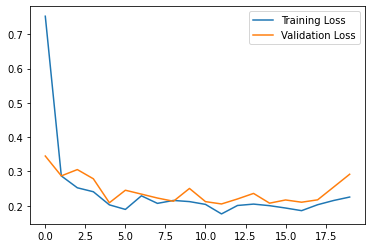

In [11]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 92.00%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [13]:
# exprimenting with the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
num_epochs = 20
train_loss_history = []
val_loss_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(num_epochs):
    # Training
    net.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_seen = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_loss_sum += loss.item() * inputs.size(0)
        train_seen += inputs.size(0)

    train_loss = train_loss_sum / train_seen
    train_acc = train_correct / train_seen * 100
    train_loss_history.append(train_loss)
    print(f"Epoch {epoch+1} training accuracy: {train_acc:.2f}% training loss: {train_loss:.5f}")

    # Validation
    net.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_seen = 0

    with torch.no_grad():
        for inputs, labels in val_loader:  # use val_loader here
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_loss_sum += loss.item() * inputs.size(0)
            val_seen += inputs.size(0)

    val_loss = val_loss_sum / val_seen
    val_acc = val_correct / val_seen * 100
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1} validation accuracy: {val_acc:.2f}% validation loss: {val_loss:.5f}")

Epoch 1 training accuracy: 96.19% training loss: 0.12690
Epoch 1 validation accuracy: 96.25% validation loss: 0.12997
Epoch 2 training accuracy: 97.28% training loss: 0.09149
Epoch 2 validation accuracy: 96.53% validation loss: 0.11877
Epoch 3 training accuracy: 97.55% training loss: 0.08175
Epoch 3 validation accuracy: 96.66% validation loss: 0.11224
Epoch 4 training accuracy: 97.75% training loss: 0.07577
Epoch 4 validation accuracy: 96.98% validation loss: 0.10731
Epoch 5 training accuracy: 97.81% training loss: 0.07316
Epoch 5 validation accuracy: 96.84% validation loss: 0.10707
Epoch 6 training accuracy: 97.97% training loss: 0.06809
Epoch 6 validation accuracy: 96.97% validation loss: 0.10309
Epoch 7 training accuracy: 97.96% training loss: 0.06672
Epoch 7 validation accuracy: 96.97% validation loss: 0.10344
Epoch 8 training accuracy: 98.12% training loss: 0.06342
Epoch 8 validation accuracy: 97.00% validation loss: 0.09929
Epoch 9 training accuracy: 98.15% training loss: 0.06181

In [15]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 97.36%


In [16]:
torch.save(net.state_dict(), "saved_AI.pth")